In [2]:

import os
import numpy as np
import pandas as pd
import pickle
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import re

from hbmep.config import Config
from hbmep.model.utils import Site as site

from models import NonHierarchicalBayesianModel
from constants import (
    DATA_PATH,
    TOML_PATH
)
from matplotlib.lines import Line2D

In [3]:
src = "/home/andres/data/hbmep-processed/J_SHAP/data.csv"
df = pd.read_csv(src)

In [4]:
file = open("/home/andres/repos/rat-mapping-paper/reports/J_SHAP/combine.pkl","rb")
combo = pickle.load(file)

In [5]:
#Create a numpy array that takes the posterior samples of specific muscles at specific positions
posmusc = [("C6M-C6L", "LBiceps"), ("C7M-C7L", "LECR"), ("C8M-C8L", "LBiceps"),("C6L-C6M", "LBiceps"), ("C7L-C7M", "LECR"), ("C8L-C8M", "LBiceps")]
charges = ["20-0-80-25", "50-0-50-0", "50-0-50-100"]
subjects = list(set([k[0] for k in combo.keys()]))
subjects.sort()

a = None
for s in subjects:
    for c in charges:
        for p in posmusc:
            pos = p[0]
            musc = p[1]
            if (s, pos, c, musc) in combo.keys():
                print(s, pos, c, musc)
                samples = combo[(s, pos, c, musc)][site.a]
                samples = samples.reshape(-1, 1)

                if a is None: a = samples
                else: a = np.concatenate((a, samples), axis=1)
            else:continue

a = a.reshape(-1, len(subjects), len(charges), 2, 2)
a.shape

amap01 C7M-C7L 20-0-80-25 LECR
amap01 C8M-C8L 20-0-80-25 LBiceps
amap01 C7L-C7M 20-0-80-25 LECR
amap01 C8L-C8M 20-0-80-25 LBiceps
amap01 C7M-C7L 50-0-50-0 LECR
amap01 C8M-C8L 50-0-50-0 LBiceps
amap01 C7L-C7M 50-0-50-0 LECR
amap01 C8L-C8M 50-0-50-0 LBiceps
amap01 C7M-C7L 50-0-50-100 LECR
amap01 C8M-C8L 50-0-50-100 LBiceps
amap01 C7L-C7M 50-0-50-100 LECR
amap01 C8L-C8M 50-0-50-100 LBiceps
amap02 C7M-C7L 20-0-80-25 LECR
amap02 C8M-C8L 20-0-80-25 LBiceps
amap02 C7L-C7M 20-0-80-25 LECR
amap02 C8L-C8M 20-0-80-25 LBiceps
amap02 C7M-C7L 50-0-50-0 LECR
amap02 C8M-C8L 50-0-50-0 LBiceps
amap02 C7L-C7M 50-0-50-0 LECR
amap02 C8L-C8M 50-0-50-0 LBiceps
amap02 C7M-C7L 50-0-50-100 LECR
amap02 C8M-C8L 50-0-50-100 LBiceps
amap02 C7L-C7M 50-0-50-100 LECR
amap02 C8L-C8M 50-0-50-100 LBiceps
amap03 C7M-C7L 20-0-80-25 LECR
amap03 C8M-C8L 20-0-80-25 LBiceps
amap03 C7L-C7M 20-0-80-25 LECR
amap03 C8L-C8M 20-0-80-25 LBiceps
amap03 C7M-C7L 50-0-50-0 LECR
amap03 C8M-C8L 50-0-50-0 LBiceps
amap03 C7L-C7M 50-0-50-0 LE

(4000, 8, 3, 2, 2)

In [6]:
len(charges)

3

In [7]:
set([k[0]+" "+k[1] for k in combo.keys()])

{'amap01 -C7L',
 'amap01 -C8L',
 'amap01 C7L-',
 'amap01 C7L-C7M',
 'amap01 C7L-C8L',
 'amap01 C7M-C7L',
 'amap01 C8L-',
 'amap01 C8L-C7L',
 'amap01 C8L-C8M',
 'amap01 C8M-C8L',
 'amap02 -C7L',
 'amap02 -C8L',
 'amap02 C7L-',
 'amap02 C7L-C7M',
 'amap02 C7L-C8L',
 'amap02 C7M-C7L',
 'amap02 C8L-',
 'amap02 C8L-C7L',
 'amap02 C8L-C8M',
 'amap02 C8M-C8L',
 'amap03 -C7L',
 'amap03 -C8L',
 'amap03 C7L-',
 'amap03 C7L-C7M',
 'amap03 C7L-C8L',
 'amap03 C7M-C7L',
 'amap03 C8L-',
 'amap03 C8L-C7L',
 'amap03 C8L-C8M',
 'amap03 C8M-C8L',
 'amap04 -C6L',
 'amap04 -C7L',
 'amap04 C6L-',
 'amap04 C6L-C6M',
 'amap04 C6L-C7L',
 'amap04 C6M-C6L',
 'amap04 C7L-',
 'amap04 C7L-C6L',
 'amap04 C7L-C7M',
 'amap04 C7M-C7L',
 'amap05 -C6L',
 'amap05 -C7L',
 'amap05 C6L-',
 'amap05 C6L-C6M',
 'amap05 C6L-C7L',
 'amap05 C6M-C6L',
 'amap05 C7L-',
 'amap05 C7L-C6L',
 'amap05 C7L-C7M',
 'amap05 C7M-C7L',
 'amap06 -C6L',
 'amap06 -C7L',
 'amap06 C6L-',
 'amap06 C6L-C6M',
 'amap06 C6L-C7L',
 'amap06 C6M-C6L',
 'ama

In [8]:
ind = 1
for i, l in enumerate(charges):
    for j, r in enumerate(charges):
        if l == r: continue
        l_samples = a[:, :, :, ind, ...][:, :, i, ...]
        r_samples = a[:, :, :, ind, ...][:, :, j, ...]
        l_samples = l_samples.mean(axis=0)
        r_samples = r_samples.mean(axis=0)

        pvalue = stats.ttest_1samp(
            l_samples - r_samples, alternative="less", popmean=0, axis=(0,1)
        ).pvalue
        print(
            f"{l}\t<\t{r}:\t\t{pvalue}"
        )
    

20-0-80-25	<	50-0-50-0:		0.33232330599077853
20-0-80-25	<	50-0-50-100:		0.5107935920698122
50-0-50-0	<	20-0-80-25:		0.6676766940092216
50-0-50-0	<	50-0-50-100:		0.6973602579922171
50-0-50-100	<	20-0-80-25:		0.4892064079301877
50-0-50-100	<	50-0-50-0:		0.30263974200778276


In [9]:
#Compare 7L-M to 7M-L
for i, l in enumerate(charges):
    for j, r in enumerate(charges):
        l_samples = a[:, :, :, 0, ...][:, :, i, ...]
        r_samples = a[:, :, :, 1, ...][:, :, j, ...]

        l_samples = l_samples.mean(axis=0)
        r_samples = r_samples.mean(axis=0)

        # r_samples -> (8, 2)

        pvalue = stats.ttest_1samp(
            l_samples - r_samples, alternative="less", popmean=0, axis=(0,1)
        ).pvalue
        r_pvalue = stats.ttest_1samp(
            l_samples - r_samples, alternative="greater", popmean=0, axis=(0,1)
        ).pvalue
        print(
            f"L-M {l}\t<\t M-L {r}: \t\t{pvalue} \t\t L-M > M-L \t\t{r_pvalue}"
        )
        
        


L-M 20-0-80-25	<	 M-L 20-0-80-25: 		0.9240831818866858 		 L-M > M-L 		0.07591681811331422
L-M 20-0-80-25	<	 M-L 50-0-50-0: 		0.7689738577626084 		 L-M > M-L 		0.23102614223739154
L-M 20-0-80-25	<	 M-L 50-0-50-100: 		0.9646128433628709 		 L-M > M-L 		0.03538715663712904
L-M 50-0-50-0	<	 M-L 20-0-80-25: 		0.9449948244007671 		 L-M > M-L 		0.055005175599232924
L-M 50-0-50-0	<	 M-L 50-0-50-0: 		0.8213948781246 		 L-M > M-L 		0.1786051218754
L-M 50-0-50-0	<	 M-L 50-0-50-100: 		0.960455042752813 		 L-M > M-L 		0.039544957247186964
L-M 50-0-50-100	<	 M-L 20-0-80-25: 		0.2846046853915059 		 L-M > M-L 		0.7153953146084941
L-M 50-0-50-100	<	 M-L 50-0-50-0: 		0.21368846837830557 		 L-M > M-L 		0.7863115316216944
L-M 50-0-50-100	<	 M-L 50-0-50-100: 		0.31456653369108956 		 L-M > M-L 		0.6854334663089103


In [10]:
LM = a[:, :,:,0, ...]
ML = a[:, :,:,1, ...]


thresh_list = []
for i, l in enumerate(charges):
    l_samples = LM[:, :, i, ...].mean(axis=0)
    sem = stats.sem(l_samples, axis=(0, 1))
    thresh_list.append(["L-M", l, l_samples.mean(), sem])

for i, r in enumerate(charges):
    m_samples = ML[:, :, i, ...].mean(axis=0)
    sem = stats.sem(m_samples, axis=(0, 1))
    thresh_list.append(["M-L",r, m_samples.mean(), sem])

In [11]:
thresh_list

[['L-M', '20-0-80-25', 212.00924374762747, 35.309000437645786],
 ['L-M', '50-0-50-0', 221.75580714961887, 33.00150355783654],
 ['L-M', '50-0-50-100', 170.2224581522745, 38.593430549231456],
 ['M-L', '20-0-80-25', 182.8780455826466, 34.38256525118727],
 ['M-L', '50-0-50-0', 195.26238297796812, 35.566760952744],
 ['M-L', '50-0-50-100', 182.45745538304539, 31.907289344342832]]

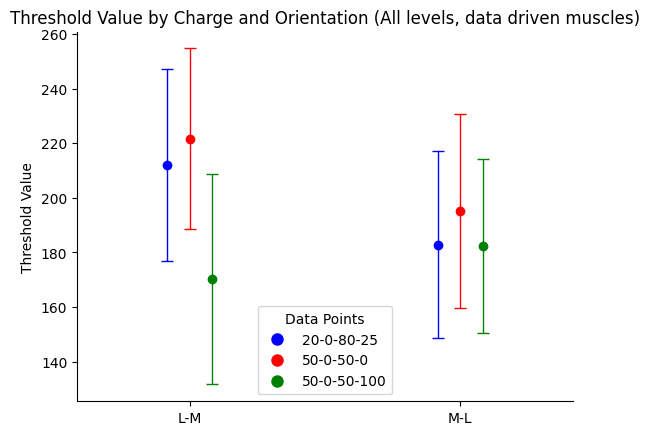

In [12]:
xpoint = [x[0] for x in thresh_list]
ypoint = [x[2] for x in thresh_list]
sem = [x[3] for x in thresh_list]
cols = [x[1] for x in thresh_list]
xpoint_new = [-.1, 0,.1, 1.1, 1.2, 1.3]
# sns.scatterplot(x=[x[0] for x in thresh_list], y=[x[2] for x in thresh_list], hue=[x[1] for x in thresh_list])
plt.xlim((-.5,1.7))
sns.despine()
plt.xticks([0, 1.2], ["L-M", "M-L"])
plt.ylabel("Threshold Value")
plt.title("Threshold Value by Charge and Orientation (All levels, data driven muscles)")

# labels = ['M-L', 'M-LL', 'M-LM1', 'M-LM2', 'M-L', 'M-LL', 'M-LM']

color_dict = {'20-0-80-25': 'blue', '50-0-50-0': 'red', '50-0-50-100': 'green'}
colors = [color_dict[col] for col in cols]
unique_labels = list(color_dict.keys())

for y, x, e, c in zip(xpoint_new, ypoint, sem, colors):
    plt.errorbar(y, x, yerr=e, fmt='o', color=c, elinewidth=1, capsize=4, ecolor=c)

legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[label], markersize=10, label=label)
                  for label in unique_labels]
plt.legend(handles=legend_handles, title='Data Points')


Analysis based on Biological Muscle Innervation

In [13]:
#Create a numpy array that takes the posterior samples of specific muscles at specific positions
posmusc = [("C6M-C6L", "LBiceps"), ("C7M-C7L", "LTriceps"), ("C8M-C8L", "LADM"),("C6L-C6M", "LBiceps"), ("C7L-C7M", "LTriceps"), ("C8L-C8M", "LADM")]
charges = ["20-0-80-25", "50-0-50-0", "50-0-50-100"]
subjects = list(set([k[0] for k in combo.keys()]))
subjects.sort()

b = None
for s in subjects:
    for c in charges:
        for p in posmusc:
            pos = p[0]
            musc = p[1]
            if (s, pos, c, musc) in combo.keys():
                samples = combo[(s, pos, c, musc)][site.a]
                samples = samples.reshape(-1, 1)

                if b is None: b = samples
                else: b = np.concatenate((b, samples), axis=1)
            else:continue

b = b.reshape(-1, len(subjects), len(charges), 2, 2)
b.shape

(4000, 8, 3, 2, 2)

In [14]:
ind = 1
for i, l in enumerate(charges):
    for j, r in enumerate(charges):
        if l == r: continue
        l_samples = b[:, :, :, ind, ...][:, :, i, ...]
        r_samples = b[:, :, :, ind, ...][:, :, j, ...]
        l_samples = l_samples.mean(axis=0)
        r_samples = r_samples.mean(axis=0)

        pvalue = stats.ttest_1samp(
            l_samples - r_samples, alternative="less", popmean=0, axis=(0,1)
        ).pvalue
        print(
            f"{l}\t<\t{r}:\t\t{pvalue}"
        )
    

20-0-80-25	<	50-0-50-0:		0.36205547438013613
20-0-80-25	<	50-0-50-100:		0.5490962841661448
50-0-50-0	<	20-0-80-25:		0.6379445256198639
50-0-50-0	<	50-0-50-100:		0.664245346205951
50-0-50-100	<	20-0-80-25:		0.45090371583385525
50-0-50-100	<	50-0-50-0:		0.3357546537940491


In [15]:
#Compare 7L-M to 7M-L
for i, l in enumerate(charges):
    for j, r in enumerate(charges):
        l_samples = b[:, :, :, 0, ...][:, :, i, ...]
        r_samples = b[:, :, :, 1, ...][:, :, j, ...]
        l_samples = l_samples.mean(axis=0)
        r_samples = r_samples.mean(axis=0)

        pvalue = stats.ttest_1samp(
            l_samples - r_samples, alternative="less", popmean=0, axis=(0,1)
        ).pvalue
        r_pvalue = stats.ttest_1samp(
            l_samples - r_samples, alternative="greater", popmean=0, axis=(0,1)
        ).pvalue
        print(
            f"L-M {l}\t<\t M-L {r}: \t\t{pvalue} \t\t L-M > M-L \t\t{r_pvalue}"
        )

L-M 20-0-80-25	<	 M-L 20-0-80-25: 		0.6236877750756683 		 L-M > M-L 		0.3763122249243317
L-M 20-0-80-25	<	 M-L 50-0-50-0: 		0.44736372542238506 		 L-M > M-L 		0.552636274577615
L-M 20-0-80-25	<	 M-L 50-0-50-100: 		0.6909890384592223 		 L-M > M-L 		0.3090109615407777
L-M 50-0-50-0	<	 M-L 20-0-80-25: 		0.8223651147487117 		 L-M > M-L 		0.17763488525128834
L-M 50-0-50-0	<	 M-L 50-0-50-0: 		0.7598877424138042 		 L-M > M-L 		0.24011225758619575
L-M 50-0-50-0	<	 M-L 50-0-50-100: 		0.8822281511257809 		 L-M > M-L 		0.11777184887421913
L-M 50-0-50-100	<	 M-L 20-0-80-25: 		0.06758129100512451 		 L-M > M-L 		0.9324187089948756
L-M 50-0-50-100	<	 M-L 50-0-50-0: 		0.09156693015450937 		 L-M > M-L 		0.9084330698454907
L-M 50-0-50-100	<	 M-L 50-0-50-100: 		0.05737581238868247 		 L-M > M-L 		0.9426241876113175


In [16]:
LM = b[:, :,:,0, ...]
ML = b[:, :,:,1, ...]


thresh_list = []
for i, l in enumerate(charges):
    l_samples = LM[:, :, i, ...].mean(axis=0)
    sem = stats.sem(l_samples, axis=(0, 1))
    thresh_list.append(["L-M", l, l_samples.mean(), sem])

for i, r in enumerate(charges):
    m_samples = ML[:, :, i, ...].mean(axis=0)
    sem = stats.sem(m_samples, axis=(0, 1))
    thresh_list.append(["M-L",r, m_samples.mean(), sem])

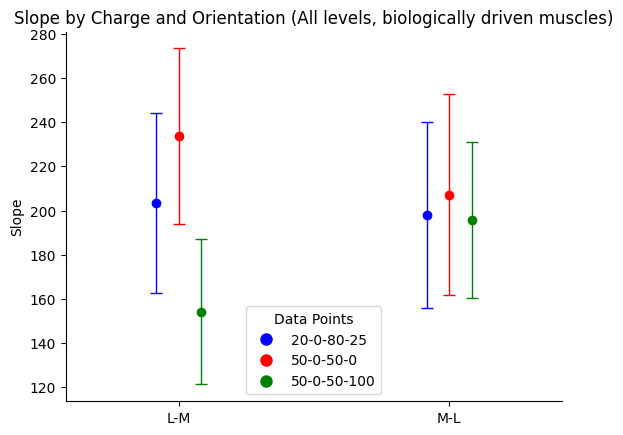

In [17]:
xpoint = [x[0] for x in thresh_list]
ypoint = [x[2] for x in thresh_list]
sem = [x[3] for x in thresh_list]
cols = [x[1] for x in thresh_list]
xpoint_new = [-.1, 0,.1, 1.1, 1.2, 1.3]
# sns.scatterplot(x=[x[0] for x in thresh_list], y=[x[2] for x in thresh_list], hue=[x[1] for x in thresh_list])
plt.xlim((-.5,1.7))
sns.despine()
plt.xticks([0, 1.2], ["L-M", "M-L"])
plt.ylabel("Slope")
plt.title("Slope by Charge and Orientation (All levels, biologically driven muscles)")

# labels = ['M-L', 'M-LL', 'M-LM1', 'M-LM2', 'M-L', 'M-LL', 'M-LM']

color_dict = {'20-0-80-25': 'blue', '50-0-50-0': 'red', '50-0-50-100': 'green'}
colors = [color_dict[col] for col in cols]
unique_labels = list(color_dict.keys())

for y, x, e, c in zip(xpoint_new, ypoint, sem, colors):
    plt.errorbar(y, x, yerr=e, fmt='o', color=c, elinewidth=1, capsize=4, ecolor=c)

legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[label], markersize=10, label=label)
                  for label in unique_labels]
plt.legend(handles=legend_handles, title='Data Points')


In [18]:
set([k[1] for k in combo.keys()])

{'-C6L',
 '-C7L',
 '-C8L',
 'C6L-',
 'C6L-C6M',
 'C6L-C7L',
 'C6M-C6L',
 'C7L-',
 'C7L-C6L',
 'C7L-C7M',
 'C7L-C8L',
 'C7M-C7L',
 'C8L-',
 'C8L-C7L',
 'C8L-C8M',
 'C8M-C8L'}